## Project McNulty Findings Notebook
### Subramanian Iyer
Data has been cleaned, models have been built. Here, we show our findings.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In the cell below, I define the functions that I'm going to use to evaluate these models.  Conceptually, the score is the average rate of return you would achieve if you invested in all the loans the model says will not charge off.

In [24]:
def ret(y_pred, y_test, X_test):
    portfolio = []
    rates = []
    for i in range(len(y_pred)):
        if y_pred[i]==0:
            portfolio.append(y_test[i])
            rates.append(X_test[i])
    if len(portfolio)==0:
        return float(-1)
    return ((float(len(portfolio)-sum(portfolio))/float(len(portfolio)))*(1.+ (np.mean(rates)/100.))) - 1
def myScore(estimator, X, y):
    y_pred = estimator.predict(X)
    return ret(list(y_pred), list(y), list(X['int_rate']))

In [25]:
with open("LCDC3.pkl", 'rb') as picklefile: 
    df1 = pickle.load(picklefile)

In the cell below, I break up my datasets into subsets based on the subgrade Lending Club has assigned to the loan. The thought being that Lending Club has its own reasoning for assigning these subgrades, so let's leverage that into our modeling by considering each subgrade separately.

In [26]:
from copy import deepcopy
varss = []
for i in df1.columns.values:
    if i != 'loan_status':
        varss.append(i)
dfs = []
Xs = []
ys = []
subgrades = sorted(list(df1.sub_grade.unique()))
a = 0
for i in subgrades:
    dfs.append(deepcopy(df1[df1.sub_grade==i]))
    Xs.append(dfs[a][varss])
    del dfs[a]['sub_grade']
    del Xs[a]['sub_grade']
    ys.append(dfs[a]['loan_status'])
    a+=1

Pretty graph. We can see the distribution of loans across subgrades. This doesn't have an effect on our modeling, but it is interesting to note.

Text(0,0.5,'Number of Loans')

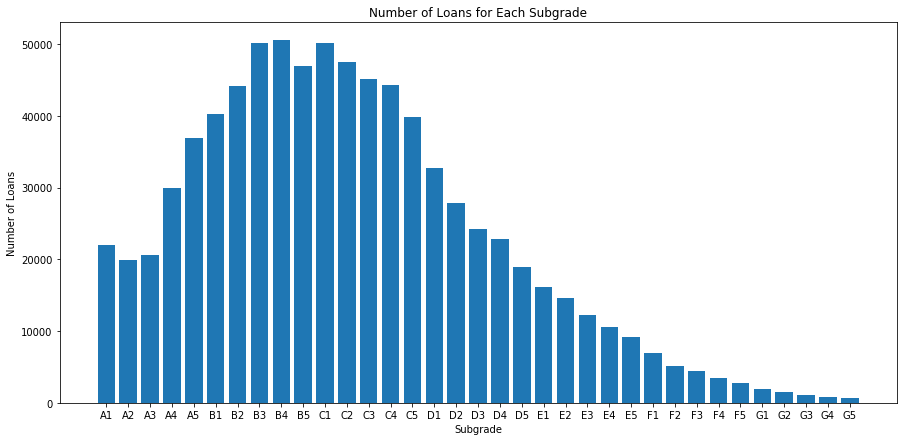

In [28]:
plt.figure(figsize =(15,7))
plt.bar(range(35), [len(x) for x in dfs], tick_label = subgrades)
plt.title('Number of Loans for Each Subgrade')
plt.xlabel('Subgrade')
plt.ylabel('Number of Loans');

Below is the frequency of charge offs in each subgrade. As we get to the riskier subgrades, the charge off rate hovers around 50%.  This is relevant for our modeling.  For the first several subgrades, we will upsample the minority class to account for the class imbalance.  We won't bother doing this for the later subgrades.

In [30]:
a = [sum(y)/len(y) for y in ys]
print(a)

[0.034506212025029473, 0.050755287009063448, 0.058045697617890128, 0.072429359638856383, 0.089847991313789358, 0.10518606787319083, 0.11585517537710034, 0.13166400638467676, 0.15042075042075043, 0.17138592750533049, 0.19066349859233672, 0.21298788694481829, 0.22988046925243386, 0.25345476678915213, 0.25748743718592965, 0.28590624522827912, 0.30102462699982024, 0.3051078601537317, 0.33323113310849284, 0.34146212721034574, 0.37107504818752718, 0.38909864762820073, 0.40516044745651997, 0.41393053710381478, 0.42213248935938014, 0.42220304860511937, 0.46366447622729029, 0.4550022841480128, 0.48954703832752611, 0.5020198310686742, 0.4847859721505931, 0.49595687331536387, 0.50141911069063383, 0.49365482233502539, 0.50391236306729259]


Text(0,0.5,'Default Rates')

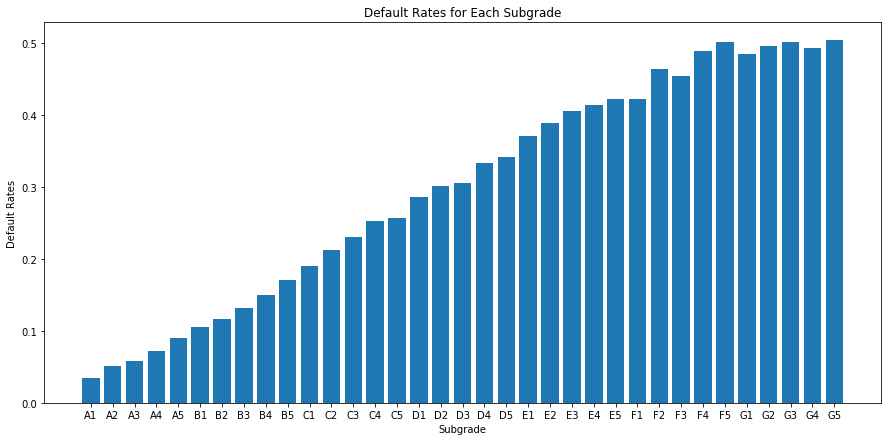

In [31]:
plt.figure(figsize =(15,7))
plt.bar(range(35), a, tick_label = subgrades)
plt.title('Default Rates for Each Subgrade')
plt.xlabel('Subgrade')
plt.ylabel('Default Rates');

Below are the average interest rates across the subgrades.  The riskier subgrades come with higher interest rates to compensate somewhat for the higher risk.

In [32]:
b = [np.mean(x['int_rate']) for x in dfs]
print(b)

[5.67678471025884, 6.5324959718046, 7.212200291686046, 7.588043136601597, 8.336042616725013, 9.00997492614406, 10.078311359361653, 10.994547885071292, 11.774066726062047, 12.262440511725107, 12.925918375492996, 13.548086305514925, 14.137084913403472, 14.75792849252082, 15.541669346733448, 16.35278943349316, 17.193550602192676, 17.802213406063206, 18.39006351014209, 19.03695698073077, 19.59019896785506, 20.184668085396364, 20.84775455213256, 21.68527139874614, 22.604125286479672, 23.52149266609342, 24.22121376111526, 24.84591822750209, 25.498556910569153, 26.043742196106994, 26.656095925734757, 27.026057951482333, 27.312999053925854, 27.856459390862533, 28.0954929577465]


Text(0,0.5,'Average Interest Rate (%)')

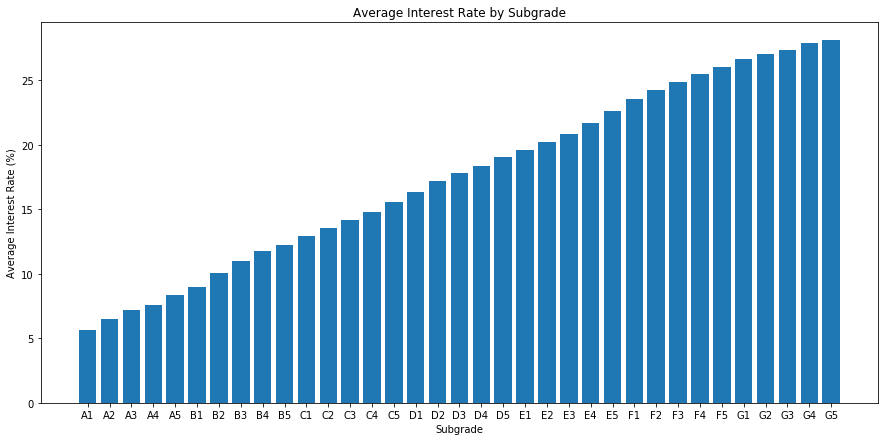

In [33]:
plt.figure(figsize =(15,7))
plt.bar(range(35), b, tick_label = subgrades)
plt.title('Average Interest Rate by Subgrade')
plt.xlabel('Subgrade')
plt.ylabel('Average Interest Rate (%)');

Below is the average rate of return across the subgrades. It is roughly the rate of return you would achieve if you invested uniformly across each subgrade. Note that only the returns for subgrades A1, A2, and A3 are positive, and the rest grow steadily more negative as the risk increases.

In [34]:
c = [100*((1-c)*(1+ (x/100.))-1) for c,x in zip(a,b)]
print(c)

[2.0302791709232437, 1.12540856296377, 0.98899333260618061, -0.20448993258010972, -1.3977331992728215, -2.4563556952921561, -2.6748307083922396, -3.6194389763330559, -5.039072268451239, -6.977761979388875, -8.6049323037311503, -10.636280663324559, -12.100801725594613, -14.328015510757242, -14.20885898154104, -16.913199715273453, -18.084594254616938, -18.140167847633982, -21.061191502128985, -21.609655566555965, -24.786739876897713, -26.579023732275541, -28.114975756325165, -28.683978348960316, -29.151059326431316, -28.629658105786117, -33.375750253750525, -31.959259732567389, -35.938889939378463, -37.232715968446165, -34.745002666421357, -35.973388579711049, -36.524171711051153, -35.260498354119107, -36.453409596861277]


Text(0,0.5,'Rate of Return (%)')

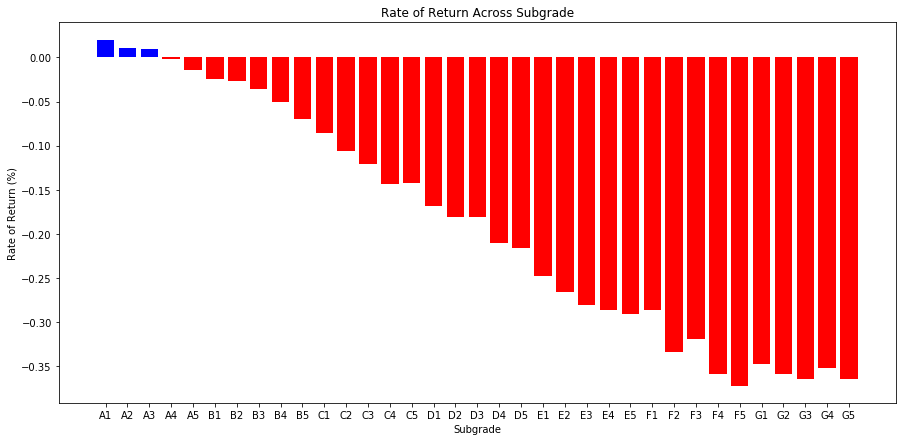

In [36]:
def col(x):
    if(x<0):
        return 'red'
    else:
        return 'blue'
plt.figure(figsize =(15,7))
plt.bar(range(35), [x/100. for x in c], color = [col(x) for x in c], tick_label = subgrades)
plt.title('Rate of Return Across Subgrade')
plt.xlabel('Subgrade')
plt.ylabel('Rate of Return (%)');

Below is a plot of return rates across subgrades achieved by logistic regression models. Note that when using logistic regression, we also manage to get a positive rate of return on the A4 and C2 subgrades, though I suspect that the C2 positive return was due to dumb luck.

Text(0,0.5,'Rate of Return (%)')

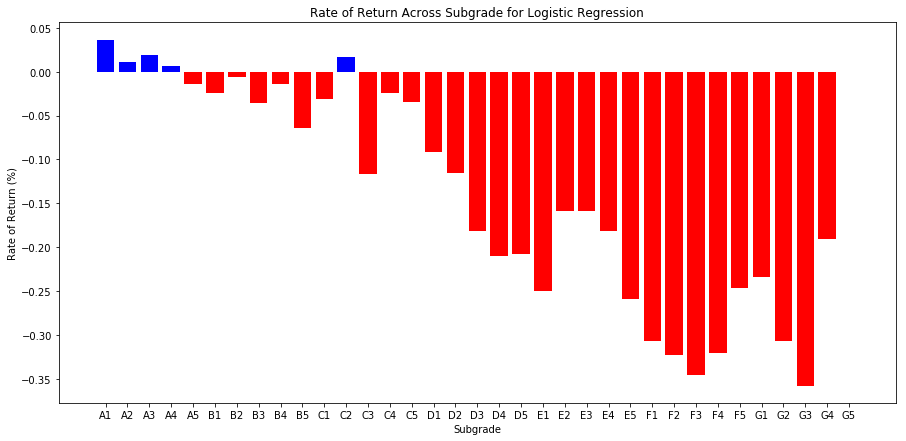

In [37]:
lrs = [0.03640466190266922, 0.01135082892545003, 0.01831884321971744, 0.006875763246001698, -0.0138873159279026, \
       -0.024039901150719634, -0.005732520274874253, -0.0361550983907738, -0.013796417388410975, -0.06385755207355992,\
       -0.030675869433949177,0.016103395201448656,-0.11605653002422256,-0.024072500000000052,-0.034618909090909256,\
       -0.09176421977183136,-0.11504386937099309,-0.1818915876375743,-0.2096561727789883,-0.20749496054314231,\
       -0.24930185138863248,-0.15865135699588484,-0.15905120660292937,-0.1808038516574435,-0.2588061119847559, \
      -0.3067068848079153, -0.3222939444684618, -0.34462124781940884, -0.31966228658003604, -0.24602776675513416,\
       -0.2338776972989286, -0.3060859960552268, -0.3570764799999999, -0.19040661625708877, 0]
plt.figure(figsize =(15,7))
plt.bar(range(35), lrs, color = [col(x) for x in lrs], tick_label = subgrades)
plt.title('Rate of Return Across Subgrade for Logistic Regression')
plt.xlabel('Subgrade')
plt.ylabel('Rate of Return (%)');

I find it a bit more illuminating to compare how logistic regression does compared to uniform investing (you can think of that as random guessing). Below I plot the improvement logistic regression gets over uniform investing. For most of the subgrades, we've improved!  I should note that for G5, our model simply told us to not invest in any of the loans, resulting in a rate of return of 0%, which is a 36% improvement over uniform investing, but nothing to be proud of.  We can always achieve 0% by not investing.

Text(0,0.5,'Rate of Return (%)')

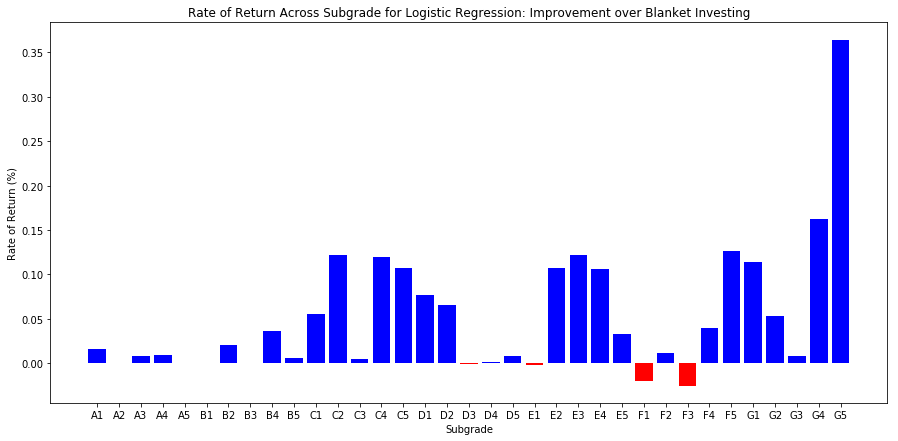

In [38]:
lris = [x-y/100. for (x,y) in zip(lrs,c)]
plt.figure(figsize =(15,7))
plt.bar(range(35), lris, color = [col(x) for x in lris], tick_label = subgrades)
plt.title('Rate of Return Across Subgrade for Logistic Regression: Improvement over Blanket Investing')
plt.xlabel('Subgrade')
plt.ylabel('Rate of Return (%)');

Below are the rates of returns achieved by random forest across the subgrades.

Text(0,0.5,'Rate of Return (%)')

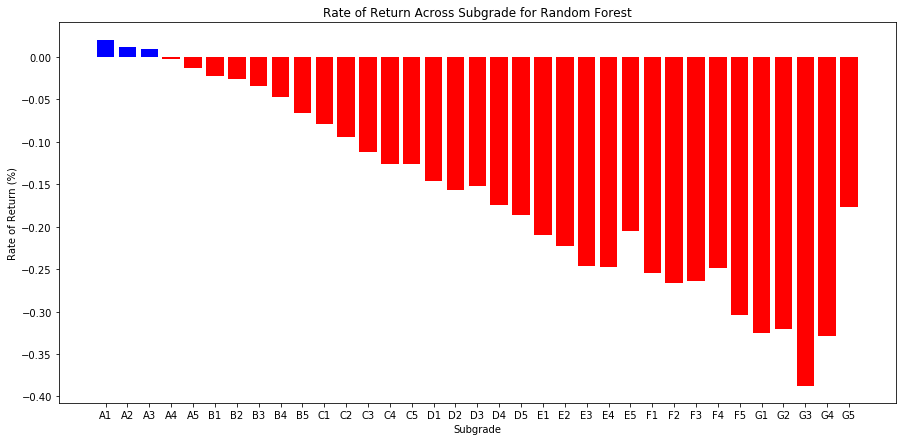

In [39]:
rfs = [0.020586562064653924, 0.01172466986623455, 0.009557374301006005, -0.0019068958728334362, -0.01284216807827887, \
      -0.022883720957889375, -0.025340840428962896, -0.03401097220913052, -0.04663847201965088, -0.06595054970926573, \
        -0.07850320109942055,-0.09404233580551646,-0.11228158764005991,-0.1261574538317256,-0.12564017610016487,\
       -0.14563272446621367,-0.1568242023078762,-0.15190912659236888,-0.17411143769663917,-0.18567775704317402,\
      -0.209498367011002,-0.2226773207100592,-0.24599985550642012,-0.2474040063554679, -0.20474321921326688, \
       -0.25439014523949066, -0.2666600862197116,-0.26430611456105557,-0.24805663594224514, -0.30433060990568883, \
       -0.3255180900496716, -0.3209502227268758, -0.3870884989269032, -0.32886291295604697, -0.176948469387755]
rfis = [x-y/100. for (x,y) in zip(rfs,c)]
plt.figure(figsize =(15,7))
plt.bar(range(35), rfs, color = [col(x) for x in rfs], tick_label = subgrades)
plt.title('Rate of Return Across Subgrade for Random Forest')
plt.xlabel('Subgrade')
plt.ylabel('Rate of Return (%)');

Below is the improvement over uniform investing achieved by random forest over each subgrade. Note how for almost all subgrades, random forest does better than uniform investing.

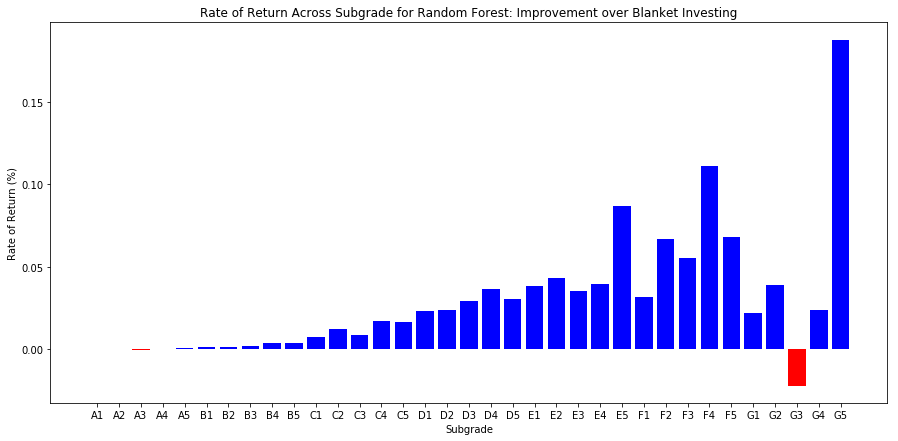

In [43]:
plt.figure(figsize =(15,7))
plt.bar(range(35), rfis, color = [col(x) for x in rfis], tick_label = subgrades)
plt.title('Rate of Return Across Subgrade for Random Forest: Improvement over Blanket Investing')
plt.xlabel('Subgrade')
plt.ylabel('Rate of Return (%)');

Now I've combined the logistic regression and random forest models like so. For a given subgrade, if random forest did better for that subgrade, use that model. If logistic regression did better, use that model. Note that clusters of subgrades all seem to prefer either random forest or logistic regression. This is interesting and I wonder why this is.

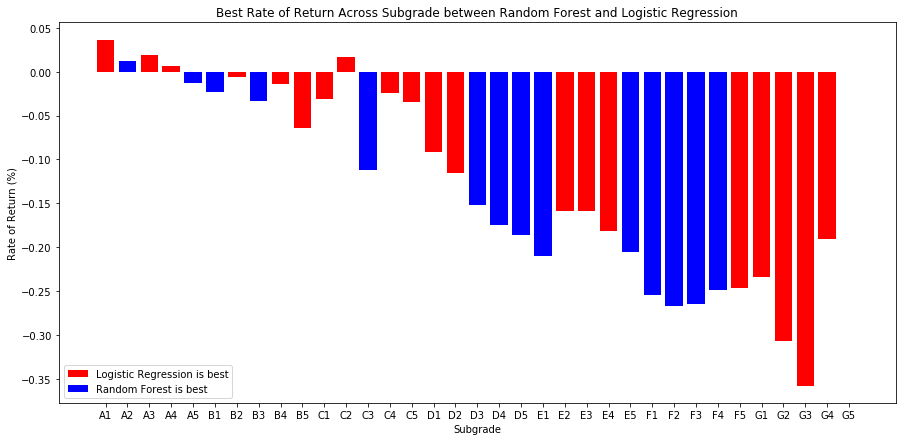

In [41]:
best = [max(x,y) for (x,y) in zip(rfs, lrs)]
cols = [col(x-y) for (x,y) in zip(rfs, lrs)] #red: lrs better, blue: rfs better
redy = [best[i] for i in range(35) if cols[i]=='red']
bluey = [best[i] for i in range(35) if cols[i]=='blue']
def lab(x):
    if(x=='red'):
        return 'Logistic Regression is best'
    else:
        return 'Random Forest is best'
def reds(x):
    ret = []
    for i in range(len(x)):
        if x[i]=='red':
            ret.append(i)
    return ret
def subred(x, inds):
    ret = []
    for i in inds:
        ret.append(x[i])
    return ret
def subblue(x, inds):
    ret=[]
    for i in inds:
        ret.append(x[i])
    return ret
def blues(x):
    ret = []
    for i in range(len(x)):
        if x[i]=='blue':
            ret.append(i)
    return ret
def base(x,inds):
    ret = []
    for i in inds:
        ret.append(x[i])
    return ret
redimp = [x-y/100. for (x,y) in zip(redy, base(c, reds(cols)))]
blueimp =[x-y/100. for (x,y) in zip(bluey, base(c, blues(cols)))]
plt.figure(figsize =(15,7))
#plt.bar(range(35), best, color = cols, label = ['Logistic Regression is best','Random Forest is best'], tick_label = subgrades)
plt.bar(reds(cols), redy, color = 'r', label = 'Logistic Regression is best')
plt.bar(blues(cols), bluey, color = 'b', label = 'Random Forest is best')
plt.xticks(range(35), subgrades)
plt.title('Best Rate of Return Across Subgrade between Random Forest and Logistic Regression')
plt.xlabel('Subgrade')
plt.ylabel('Rate of Return (%)')
plt.legend(loc = 'lower left');

Below is the comparison of our synthesized model to uniform investing.  When you combine our logistic regression and random forest, we beat uniform investing over all subgrades.

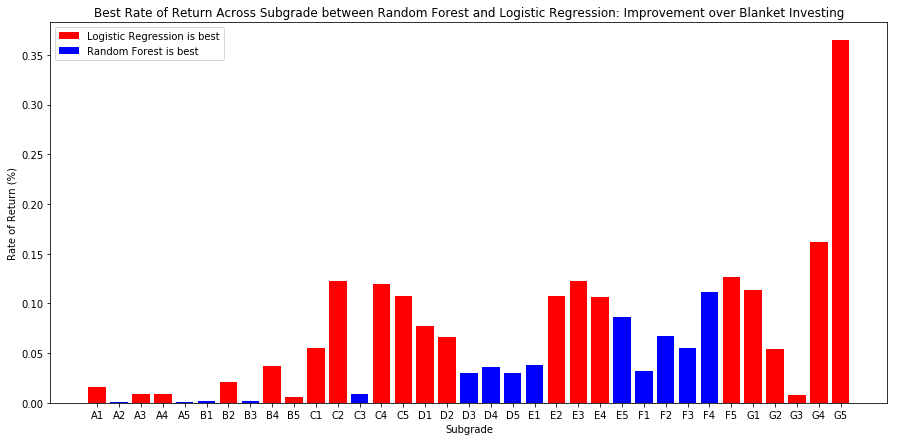

In [42]:
plt.figure(figsize =(15,7))
plt.bar(reds(cols), redimp, color = 'r', label = 'Logistic Regression is best')
plt.bar(blues(cols), blueimp, color = 'b', label = 'Random Forest is best')
plt.xticks(range(35), subgrades)
plt.title('Best Rate of Return Across Subgrade between Random Forest and Logistic Regression: Improvement over Blanket Investing')
plt.xlabel('Subgrade')
plt.ylabel('Rate of Return (%)')
plt.legend(loc = 'upper left');